# Import Library

In [1]:
# upload files to google colab
from google.colab import files

# data preparation
import os
import numpy as np
import glob
from PIL import ImageFile

# image augmentation and processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# image visualization
import matplotlib.pyplot as plt

# modelling
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Nadam


# Kaggle API for Dataset

In [2]:
# upload file to google colabs
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kurnivannoery","key":"9d65720ebbcb40894e71244fd64ecac1"}'}

In [3]:
# create .kaggle folder inside the root folder
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# copy kaggle.json file in the current active directory to .kaggle folder
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!rm -rf /content/face-shape-dataset.zip

In [5]:
# downloading datasets using Kaggle CLI
!kaggle datasets download -d niten19/face-shape-dataset

 97% 623M/639M [00:02<00:00, 190MB/s]
100% 639M/639M [00:02<00:00, 274MB/s]


In [6]:
# Extract the zip file
%rm -rf dataset
%mkdir dataset
%cd dataset
!unzip /content/face-shape-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (163).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (189).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (192).jpg  
  inflating:

# Data Preparation

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
!rm -rf '/content/dataset/FaceShape Dataset/testing_set/Round/desktop.ini'
!rm -rf '/content/dataset/FaceShape Dataset/desktop.ini'
!rm -rf '/content/dataset/FaceShape Dataset/training_set/desktop.ini'

In [9]:
base_dir = '/content/dataset/FaceShape Dataset'
train_dir = os.path.join(base_dir, 'training_set')
valid_dir = os.path.join(base_dir, 'testing_set')
test_dir = os.path.join(base_dir, 'testing_set')

In [10]:
total_train = len(list(glob.iglob(train_dir +"//*/*.*", recursive=True)))
print("Total Training Image\t:{}".format(total_train))

for x in os.listdir(train_dir):
  print('{}\t\t\t:{}'.format(x, str(len(list(glob.iglob(train_dir + '/'+ x + "//*.*", recursive=True))))))

Total Training Image	:4000
Round			:800
Oblong			:800
Square			:800
Oval			:800
Heart			:800


In [11]:
# valid == test
total_valid = len(list(glob.iglob(valid_dir +"//*/*.*", recursive=True)))
print("Total Validation Image\t:{}".format(total_valid))

for x in os.listdir(train_dir):
  print('{}\t\t\t:{}'.format(x, str(len(list(glob.iglob(valid_dir + '/'+ x + "//*.*", recursive=True))))))

Total Validation Image	:1000
Round			:200
Oblong			:200
Square			:200
Oval			:200
Heart			:200


# Image Augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


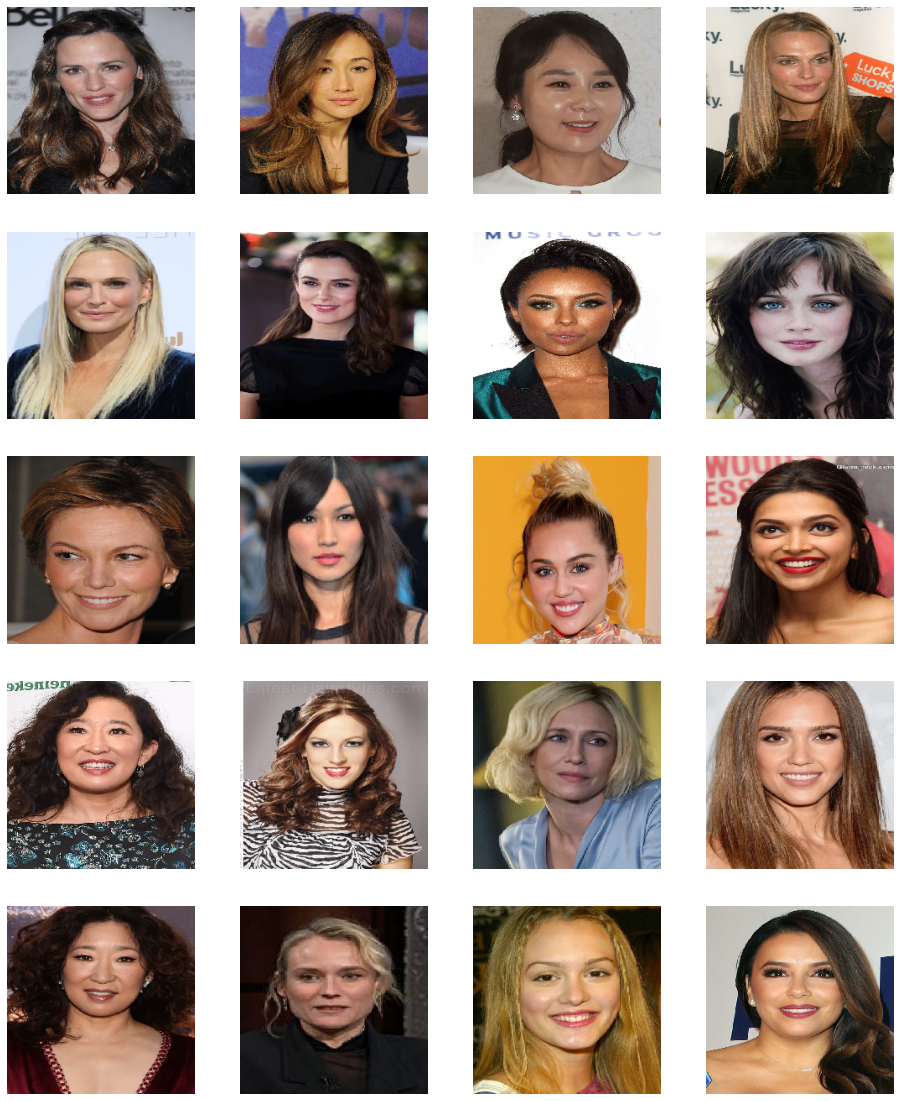

In [14]:
plt.figure(figsize=(16, 20))

for i in range(20):
    img, label = train_generator.next()
    plt.subplot(5, 4, i+1)
    plt.imshow(img[0])
    plt.axis('off')
    
plt.show()

In [15]:
varians_dict = train_generator.class_indices
print(varians_dict)

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


# Modelling - Transfer Learning

In [16]:
clear_session()

pre_trained_model = MobileNetV2(
    include_top = False,
    input_shape = (224,224,3),
    weights='imagenet'
)
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [17]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model # not get_layer because i dont know separate layer

In [18]:
x = GlobalAveragePooling2D()(last_layer.output)
x = Dense(512, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_generator,
              validation_data = valid_generator,
              epochs=15)

Epoch 1/15
250/250 [==============================] - 63s 231ms/step - loss: 1.5220 - acc: 0.3505 - val_loss: 1.4154 - val_acc: 0.4040
Epoch 2/15
250/250 [==============================] - 56s 224ms/step - loss: 1.2958 - acc: 0.4700 - val_loss: 1.3985 - val_acc: 0.4400
Epoch 3/15
250/250 [==============================] - 57s 227ms/step - loss: 1.1644 - acc: 0.5410 - val_loss: 1.4480 - val_acc: 0.3980
Epoch 4/15
250/250 [==============================] - 56s 224ms/step - loss: 1.0534 - acc: 0.5882 - val_loss: 1.4974 - val_acc: 0.3970
Epoch 5/15
250/250 [==============================] - 56s 225ms/step - loss: 0.9274 - acc: 0.6423 - val_loss: 1.3992 - val_acc: 0.4650
Epoch 6/15
250/250 [==============================] - 57s 228ms/step - loss: 0.7923 - acc: 0.7048 - val_loss: 1.4420 - val_acc: 0.4450
Epoch 7/15
250/250 [==============================] - 57s 230ms/step - loss: 0.6711 - acc: 0.7523 - val_loss: 1.5617 - val_acc: 0.4430
Epoch 8/15
250/250 [==============================] - 5

# Model Evaluation

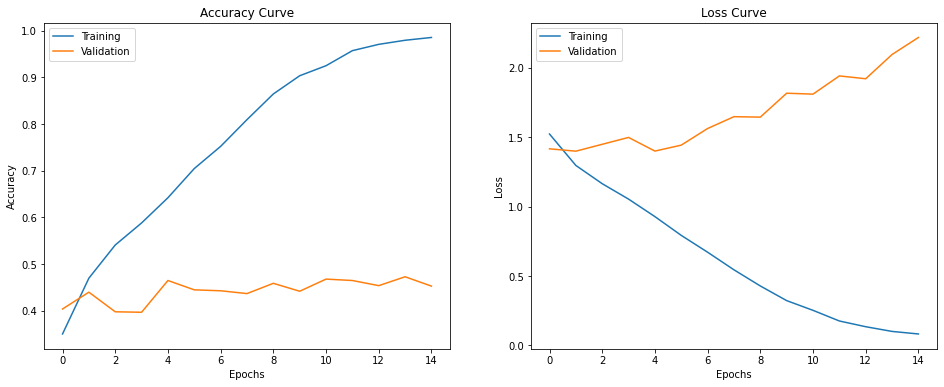

In [20]:
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [21]:
for varian in varians_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, varian))    
#    plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/dataset/FaceShape Dataset/testing_set/{varian}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img)
        img_array = img_array/255.
        img_array = tf.expand_dims(img_array, 0)

        varians_list = list(varians_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_varian = varians_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_varian == varian:
            correct_count += 1

        #plt.subplot(20, 10, idx+1)
        #plt.title(f'Actual: {varian}\nPrediction: {pred_varian} {pred_confidence:.2f}%')
        #plt.imshow(img)
        #plt.axis('off')
    
    print(f'{varian} Predictions --> {correct_count}/200 correct')
#plt.show()

Heart Predictions --> 109/200 correct
Oblong Predictions --> 99/200 correct
Oval Predictions --> 80/200 correct
Round Predictions --> 103/200 correct
Square Predictions --> 62/200 correct


# Save Model

In [22]:
%rm -rf '/content/model'
%mkdir '/content/model'
%cd '/content/model'
model.save("face_shape.h5")

/content/model
